<!-- Banner Image -->
<img src="https://uohmivykqgnnbiouffke.supabase.co/storage/v1/object/public/landingpage/brevdevnotebooks.png" width="100%">

<!-- Links -->
<center>
  <a href="https://console.brev.dev" style="color: #06b6d4;">Console</a> •
  <a href="https://brev.dev" style="color: #06b6d4;">Docs</a> •
  <a href="/" style="color: #06b6d4;">Templates</a> •
  <a href="https://discord.gg/NVDyv7TUgJ" style="color: #06b6d4;">Discord</a>
</center>

# Fine-tune and deploy the multimodal LLaVA model with DeepSpeed🤙

Hi everyone!

In this notebook we'll fine-tune the LLaVA model. LLaVA is multimodal which means it can ingest and understand images along with text! LLaVA comes from a research paper titled [Visual Instruction Tuning](https://arxiv.org/abs/2304.08485) and introduces the Large Language and Vision Assistant methodology. In order to process images, LLaVA relies on the pre-trained CLIP visual encoder ViT-L/14 which maps images and text into the same latent space. 

Help us make this tutorial better! Please provide feedback on the [Discord channel](https://discord.gg/RN2a436M73) or on [X](https://x.com/brevdev).

## Table of contents 

1. Data Preprocessing
2. LLaVA Installation
3. DeepSpeed configuration
4. Weights and Biases
5. Finetuning flow
6. Deployment via gradio interface

## Data Preprocessing 

LLaVA requires data to be in a very specific format. Below we use a [helper function](https://wandb.ai/byyoung3/ml-news/reports/How-to-Fine-Tune-LLaVA-on-a-Custom-Dataset--Vmlldzo2NjUwNTc1) to format the OKV-QA dataset. This dataset teaches the model to respond to an image in short phrases without any preamble or extra verbiage. 

### Optional: create your own dataset using GPT-4o

The guide to creating your own dataset is relatively simple! Here's a simple script that you could use that leverages GPT4o's multimodal capabilities to quickly create a dataset that can be used in the dataset creator function that we write below!
 

```python
import os
import base64
import requests
import json

# OpenAI API Key
api_key = "<enter key here>"

# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Path to your images folder
folder_path = "<enter image folder path here>"

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
}

# Question to ask for each image
question = "Generate a detailed description about this image" #change this depending on your use case

# Function to process each image and get the description
def process_image(image_path, image_name):
    base64_image = encode_image(image_path)
    
    payload = {
        "model": "gpt-4o",
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": question
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}"
                        }
                    }
                ]
            }
        ],
        "max_tokens": 300
    }

    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    response_json = response.json()
    return response_json['choices'][0]['message']['content']

# List to store all JSON data
all_json_data = []

# Process each image in the folder
for image_name in os.listdir(folder_path):
    if image_name.endswith((".jpg", ".jpeg", ".png")):
        image_path = os.path.join(folder_path, image_name)
        formatted_answers = process_image(image_path, image_name)
        
        json_data = {
            "id": image_name.split('.')[0],
            "image": image_name,
            "conversations": [
                {
                    "from": "human",
                    "value": question
                },
                {
                    "from": "gpt",
                    "value": formatted_answers
                }
            ]
        }
        
        all_json_data.append(json_data)

# Save the results to a JSON file
output_file = "output.json"
with open(output_file, "w") as outfile:
    json.dump(all_json_data, outfile, indent=4)

print(f"Data has been saved to {output_file}")

```
How to use this script
1. Create a folder called dataset. Inside of this folder, create a subfolder called images.
2. Place all your images in a directory and specify that path as folder_path.
3. Outputs are saved in a JSON file in the specified output_folder, pairing each image file with its generated description. 
4. After the script is run, create another folder inside dataset called train and move the output.json file into this folder.

## Back to it!

In [ ]:
# Install preprocessing libraries
!pip install datasets
!pip install --upgrade --force-reinstall Pillow

In [ ]:
# Imports
from datasets import load_dataset
from PIL import Image
from io import BytesIO
import requests
import os
import json
import uuid

# Check PIL import
import PIL.Image

# Define preprocessing functions
def process_and_save(dataset, output_folder, subset_name):
    # Define image subfolder within output folder
    subset_folder = os.path.join(output_folder, subset_name)
    image_subfolder = os.path.join(output_folder, 'images')

    if not os.path.exists(image_subfolder):
        os.makedirs(image_subfolder)

    if not os.path.exists(subset_folder):
        os.makedirs(subset_folder)

    # Initialize list to hold all JSON data
    json_data_list = []

    # Process and save images and labels
    for item in dataset:
        # Load image if it's a URL or a file path
        if isinstance(item['image'], str):
            response = requests.get(item['image'])
            image = Image.open(BytesIO(response.content))
        else:
            image = item['image']  # Assuming it's a PIL.Image object

        # Create a unique ID for each image
        unique_id = str(uuid.uuid4())

        # Define image path
        image_path = os.path.join(image_subfolder, f"{unique_id}.jpg")

        # Save image
        image.save(image_path)

        # Remove duplicates and format answers
        answers = item['answers']
        unique_answers = list(set(answers))
        formatted_answers = ", ".join(unique_answers)

        # Structure for LLaVA JSON
        json_data = {
            "id": unique_id,
            "image": f"{unique_id}.jpg",
            "conversations": [
                {
                    "from": "human",
                    "value": item['question']
                },
                {
                    "from": "gpt",
                    "value": formatted_answers
                }
            ]
        }

        # Append to list
        json_data_list.append(json_data)

    # Save the JSON data list to a file
    json_output_path = os.path.join(output_folder, subset_name, 'dataset.json')
    with open(json_output_path, 'w') as json_file:
        json.dump(json_data_list, json_file, indent=4)

def save_dataset(dataset_name, output_folder, class_name, subset_name, val_samples=None):
    # Load the dataset from Hugging Face
    dataset = load_dataset(dataset_name, split=subset_name)

    # Filter for images with the specified class in 'question_type'
    filtered_dataset = [item for item in dataset if item['question_type'] == class_name]

    # Determine the split for training and validation
    if val_samples is not None and subset_name == 'train':
        train_dataset = filtered_dataset[val_samples:]
        val_dataset = filtered_dataset[:val_samples]
    else:
        train_dataset = filtered_dataset
        val_dataset = []

    # Process and save the datasets
    for subset, data in [('train', train_dataset), ('validation', val_dataset)]:
        if data:
            process_and_save(data, output_folder, subset)

In [ ]:
# Create dataset
output_folder = 'dataset'
class_name = 'other'
val_samples = 300
save_dataset('Multimodal-Fatima/OK-VQA_train', output_folder, class_name, 'train', val_samples)
save_dataset('Multimodal-Fatima/OK-VQA_test', output_folder, class_name, 'test')

## Install LLaVA

To install the functions needed to use the model, we have to clone the original LLaVA repository and and install it in editable mode. This lets us access all functions and helper methods 

In [ ]:
# The pip install -e . lets us install the repository in editable mode
!git clone https://github.com/haotian-liu/LLaVA.git
!cd LLaVA && pip install --upgrade pip && pip install -e .

## DeepSpeed

Microsoft DeepSpeed is a deep learning optimization library designed to enhance the training speed and scalability of large-scale artificial intelligence (AI) models. Developed by Microsoft, this open-source tool specifically addresses the challenges associated with training very large models, allowing for reduced computational times and resource usage. By optimizing memory management and introducing novel parallelism techniques, DeepSpeed enables developers and researchers to train models with billions of parameters efficiently, even on limited hardware setups.DeepSpeed API is a lightweight wrapper on PyTorch. DeepSpeed manages all of the boilerplate training techniques, such as distributed training, mixed precision, gradient accumulation, and checkpoints and allows you to just focus on model development. To learn more about DeepSpeed and how it performs the magic, check out this [article](https://www.deepspeed.ai/2021/03/07/zero3-offload.html) on DeepSpeed and ZeRO.

Using deepspeed is extremely simple - you simply pip install it! The LLaVA respository contains the setup scripts and configuration files needed to finetune in different ways. 

In [ ]:
!cd LLaVA && pip install -e ".[train]"
!pip install flash-attn --no-build-isolation

In [ ]:
!pip install deepspeed

## Weights and Biases

Weights and Biases is an industry standard MLOps tool to used to monitor and evaluate training jobs. At Brev, we use Weights and Biases to track all of our finetuning jobs! Its extremely easy to setup and plugs into the DeepSpeed training loop. You simply create an account and use the cells below to log in!

In [ ]:
!pip install wandb

In [ ]:
import wandb

wandb.login()

## Finetuning job

Below we start the DeepSpeed training run for 5 epochs. It will automatically recognize multiple GPUs and parallelize across them. Most of the input flags are standard but you can adjust your training run with the `num_train_epochs` and `per_device_train_batch_size` flags!

In [ ]:
!deepspeed LLaVA/llava/train/train_mem.py \
    --lora_enable True --lora_r 128 --lora_alpha 256 --mm_projector_lr 2e-5 \
    --deepspeed LLaVA/scripts/zero3.json \
    --model_name_or_path liuhaotian/llava-v1.5-13b \
    --version v1 \
    --data_path ./dataset/train/dataset.json \
    --image_folder ./dataset/images \
    --vision_tower openai/clip-vit-large-patch14-336 \
    --mm_projector_type mlp2x_gelu \
    --mm_vision_select_layer -2 \
    --mm_use_im_start_end False \
    --mm_use_im_patch_token False \
    --image_aspect_ratio pad \
    --group_by_modality_length True \
    --bf16 True \
    --output_dir ./checkpoints/llava-v1.5-13b-task-lora \
    --num_train_epochs 1 \
    --per_device_train_batch_size 16 \
    --per_device_eval_batch_size 4 \
    --gradient_accumulation_steps 1 \
    --evaluation_strategy "no" \
    --save_strategy "steps" \
    --save_steps 50000 \
    --save_total_limit 1 \
    --learning_rate 2e-4 \
    --weight_decay 0. \
    --warmup_ratio 0.03 \
    --lr_scheduler_type "cosine" \
    --logging_steps 1 \
    --tf32 True \
    --model_max_length 2048 \
    --gradient_checkpointing True \
    --dataloader_num_workers 4 \
    --lazy_preprocess True \
    --report_to wandb

Here's an excerpt from my WandB run!

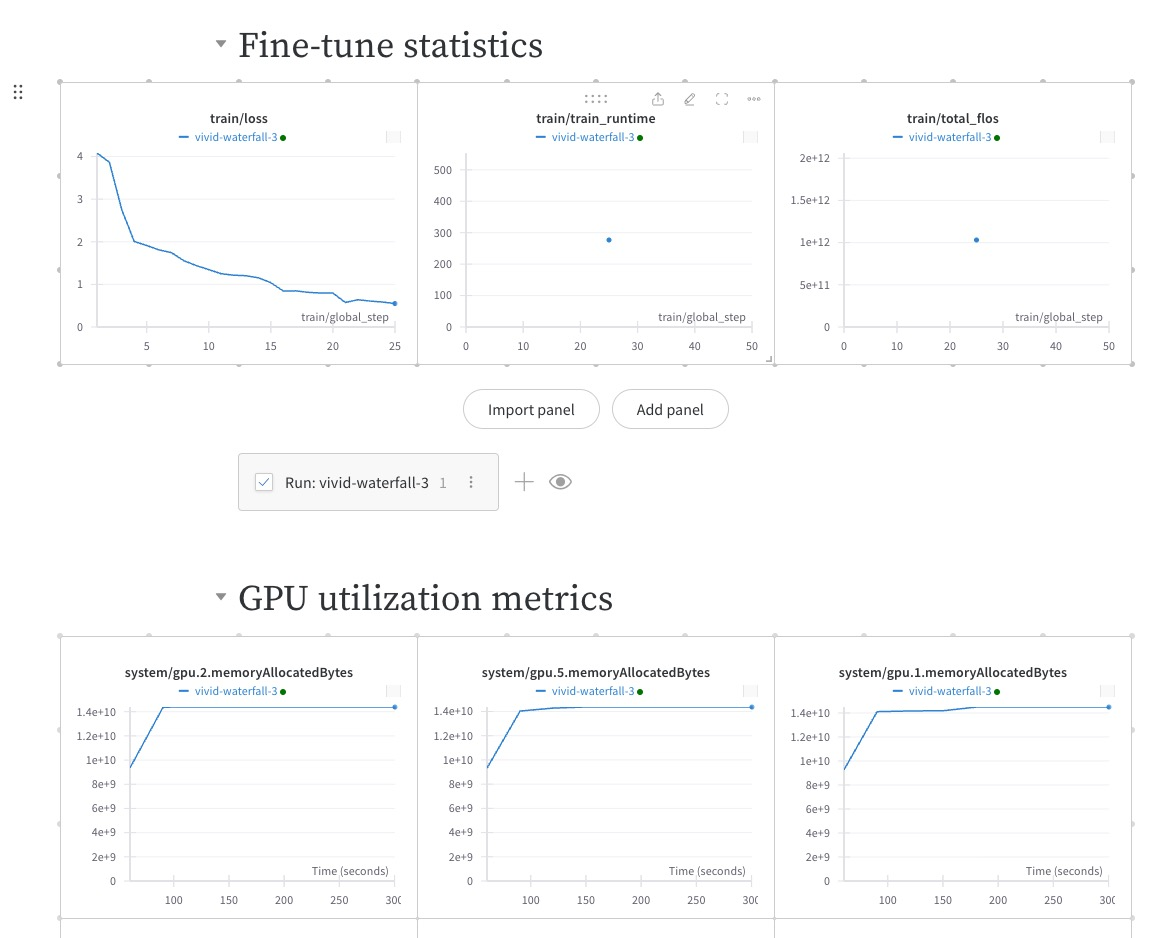

In [ ]:
# merge the LoRA weights with the full model
!python LLaVA/scripts/merge_lora_weights.py --model-path checkpoints/llava-v1.5-13b-task-lora --model-base liuhaotian/llava-v1.5-13b --save-model-path llava-ftmodel

In [ ]:
# bump transformers down for gradio/deployment inference if needed
!pip install transformers==4.37.2

## Deployment

LLaVA gives us 2 ways to deploy the model - via CLI or Gradio UI. We suggest using the Gradio UI for interactivity as you can compare two models and see the finetuning effect compared to the original model.

In [ ]:
# Uncomment the lines below to run the CLI. You need to pass in a JPG image URL to use the multimodal capabilities

# !python -m llava.serve.cli \
#     --model-path llava-ftmodel \
#     --image-file "https://llava-vl.github.io/static/images/view.jpg"

In [ ]:
# Download the model runner
!wget -L https://raw.githubusercontent.com/brevdev/notebooks/main/assets/llava-deploy.sh 

In [ ]:
# Run inference! Use the public link provided in the output to test
!chmod +x llava-deploy.sh && ./llava-deploy.sh